<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Machine%20Learning%20Methods/ML_Airline_With_Differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [70]:
pip install -U scikit-learn

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [72]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [73]:
df['LogPassengers'] = np.log(df['Passengers'])

In [74]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [75]:
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [76]:
Ntest = 12 #Ntest=12 cause we want to process it by month
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [77]:
series = df['DiffLogPassengers'].to_numpy()[1:]
series

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ,  0.09134978,  0.11247798, -0.04348511,
       -0.07696104,  0.17563257,  0.13185213,  0.        , -0.0732034 ,
       -0.1722459 , -0.15415068,  0.20544397,  0.03509132,  0.03390155,
        0.17114826, -0.08803335,  0.05374428,  0.03428907,  0.11152127,
        0.        , -0.07836907, -0.12733942, -0.10398971,  0.12838117,
        0.02967577,  0.05129329,  0.06973334, -0.06419316,  0.01098912,
        0.17500891,  0.05358425,  0.05085842, -0.14660347, -0.09006082,
       -0.10477895,  0.12036368,  0.0102565 ,  0.        ,  0.18571715,
       -0.00424629, -0.02586351,  0.05933944,  0.08288766,  0.02985296,
       -0.13774193, -0.11620201, -0.15890128,  0.11034806,  0.01481509,
       -0.08167803,  0.22314355, -0.0346355 ,  0.0303711 ,  0.12062799,
        0.13447791, -0.03025441, -0.12334455, -0.12310606, -0.12

In [78]:
# Make supervised dataset
# Lets see if we can use T past values to predict the next value


T = 10
x = []
y = []
for t in range(len(series) - T):
  X = series[t:t+T]
  x.append(X)
  Y = series[t+T]
  y.append(Y)

x = np.array(x).reshape(-1, T)
y = np.array(y)
N = len(x)
print('x.shape', x.shape, "y.shape", y.shape)

x.shape (133, 10) y.shape (133,)


In [79]:
xtrain, ytrain = x[:-Ntest], y[:-Ntest]
xtest, ytest = x[-Ntest:], y[-Ntest:]

In [80]:
from sklearn.linear_model import LinearRegression

In [81]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
lr.score(xtrain, ytrain)

0.6837135048453121

In [82]:
lr.score(xtest, ytest)

0.6492870172668166

In [83]:
# Boolean Index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False #first T+1 values are not predictable

In [84]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [85]:
# Last known train value
last_train = train.iloc[-1]['LogPassengers']

In [86]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(xtest)

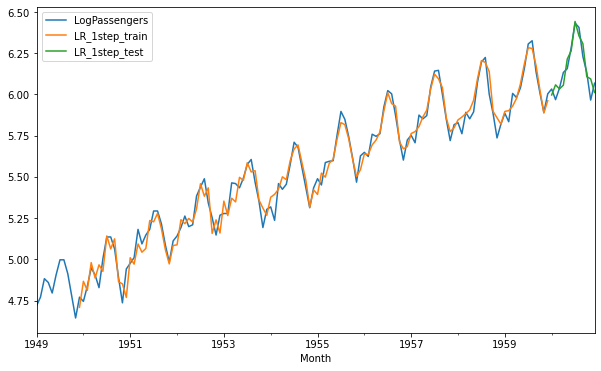

In [87]:
# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(10, 6))

You can see that the results look pretty good, much better than before, we now do not have a problem reaching the peak.

In [88]:
# multi step forecast
multistep_predictions = []

# first test input
last_x = xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [89]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)
# cumsum is Return the cumulative sum of the elements along a given axis

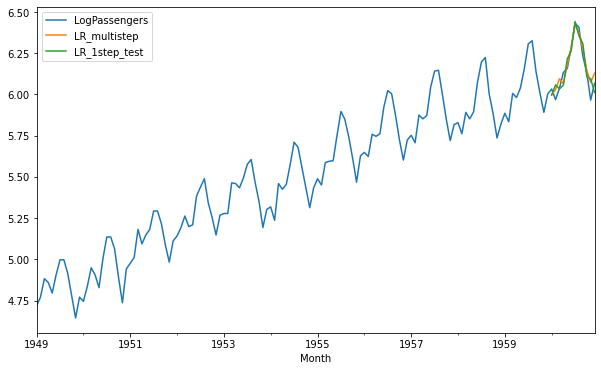

In [90]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(10, 6))

We see that the multistep prediction is also pretty good.

In [91]:
# Make multi-output supervised dataset
Tx = T
Ty = Ntest
x = []
y = []
for t in range(len(series) - Tx - Ty + 1):
  X = series[t:t+Tx]
  x.append(X)
  Y = series[t+Tx:t+Tx+Ty]
  y.append(Y)

x = np.array(x).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (122, 10) y.shape (122, 12)


In [92]:
xtrain_m, ytrain_m = x[:-1], y[:-1]
xtest_m, ytest_m = x[-1:], y[-1:]

In [93]:
lr = LinearRegression()
lr.fit(xtrain_m, ytrain_m)
lr.score(xtrain_m, ytrain_m)

0.8141637147930583

In [94]:
from sklearn.metrics import r2_score
r2_score(lr.predict(xtest_m).flatten(), ytest_m.flatten())

0.7690077978619654

In [95]:
# save multi output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(xtest_m).flatten())

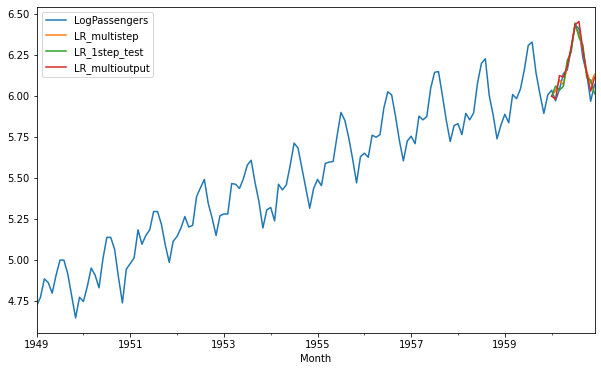

In [96]:
# plot all forecast
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(10, 6))

We again see that the forecast is pretty good, but it's hard to tell from this plot.

Which one is best?


In [97]:
from sklearn.metrics import mean_absolute_percentage_error
#MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multistep']
)
print('multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput']
)
print('multi-output MAPE:', mape2)

multi-step MAPE: 0.007109281288502525
multi-output MAPE: 0.005245261617574879


### TEST OTHER MODELS

In [103]:
def one_step_and_multistep_forecast(model, name):
  model.fit(xtrain, ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = \
    prev[train_idx] + model.predict(xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = \
    prev[test_idx] + model.predict(xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = \
    last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.012149122102392764


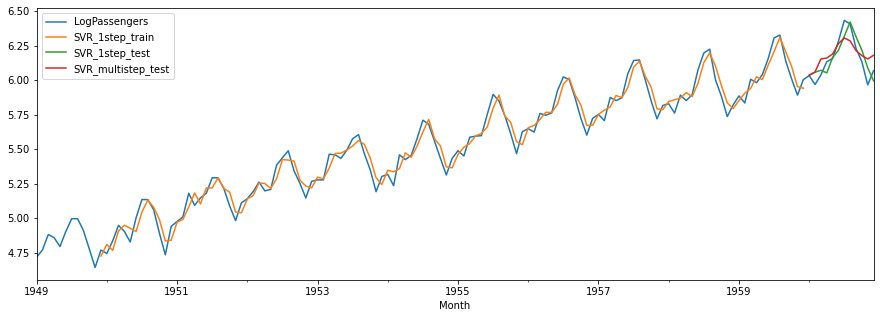

In [104]:
from sklearn import svm
from sklearn.svm import SVR
one_step_and_multistep_forecast(SVR(), 'SVR')

One-step forecast: RF
Test MAPE (multi-step): 0.005273828448677658


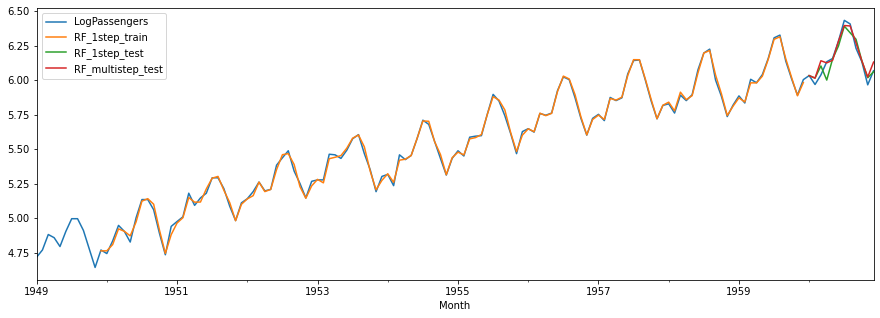

In [105]:
# import sklearn
one_step_and_multistep_forecast(RandomForestRegressor(), 'RF')

In [106]:
def multi_output_forecast(model, name):
  model.fit(xtrain_m, ytrain_m)

  # save multioutput forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(xtest_m).flatten())

  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multioutput']
  )
  print('Test MAPE (multioutput):', mape)
  # plot all forecast
  # assume that previous function have been run
  cols = [
          'LogPassengers',
          f'{name}_1step_train',
          f'{name}_1step_test',
          f'{name}_multistep_test',
          f'{name}_multioutput',
  ]

  df[cols].plot(figsize=(10, 6))

In [107]:
# multi_output_forecast(SVR(), 'SVR') #CANNOT HANDLE MULTIOUTPUT

In [108]:
class SVRWrapper:
  def __init__(self, h, **args):
    self.h = h
    self.models = [SVR(**args) for _ in range(h)]

  def fit(self, x, y):
    for k in range(self.h):
      self.models[k].fit(x, y[:, k])
      
  def predict(self, x):
    p = [m.predict(x) for m in self.models]
    return np.hstack(p)

Test MAPE (multioutput): 0.010731361803536803


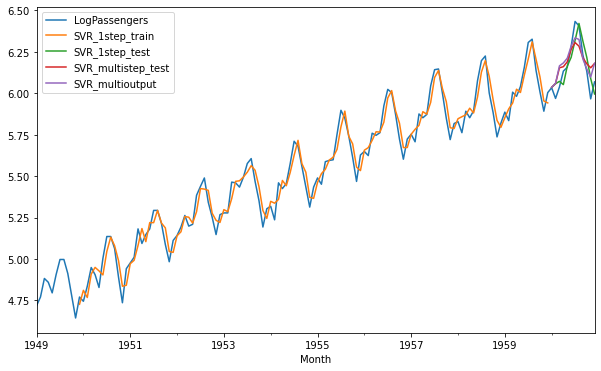

In [109]:
multi_output_forecast(SVRWrapper(Ntest), 'SVR')

Test MAPE (multioutput): 0.00461109387228362


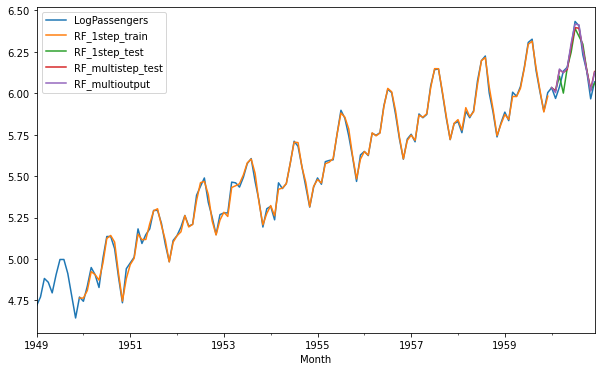

In [110]:
multi_output_forecast(RandomForestRegressor(), 'RF')